In [3]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import hashlib
from imageio import imread
import numpy as np

In [113]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Flatten,Dense,Input,Dropout,Conv2D,MaxPool2D,Activation
from tensorflow.keras.models import Model,Sequential
from keras import optimizers

In [5]:
IMAGE_SIZE = [224,224]
batch_size = 32

In [87]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [88]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [89]:
train_set = train_datagen.flow_from_directory('DataSet/train',
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='sparse')

Found 6506 images belonging to 5 classes.


In [90]:
val_set = train_datagen.flow_from_directory('DataSet/validation',
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='sparse')

Found 1161 images belonging to 5 classes.


In [91]:
print(len(train_set))
print(len(val_set))

204
37


In [92]:
class_names = list(train_set.class_indices.keys())
print(class_names)

['drawings', 'hentai', 'neutral', 'porn', 'sexy']


In [93]:
data_iterator = train_set
batch = data_iterator.next()
print(batch[0].shape[0])
batch[0].shape

32


(32, 224, 224, 3)

In [94]:
print(batch[0].max())
print(batch[0].min())

1.0
0.0


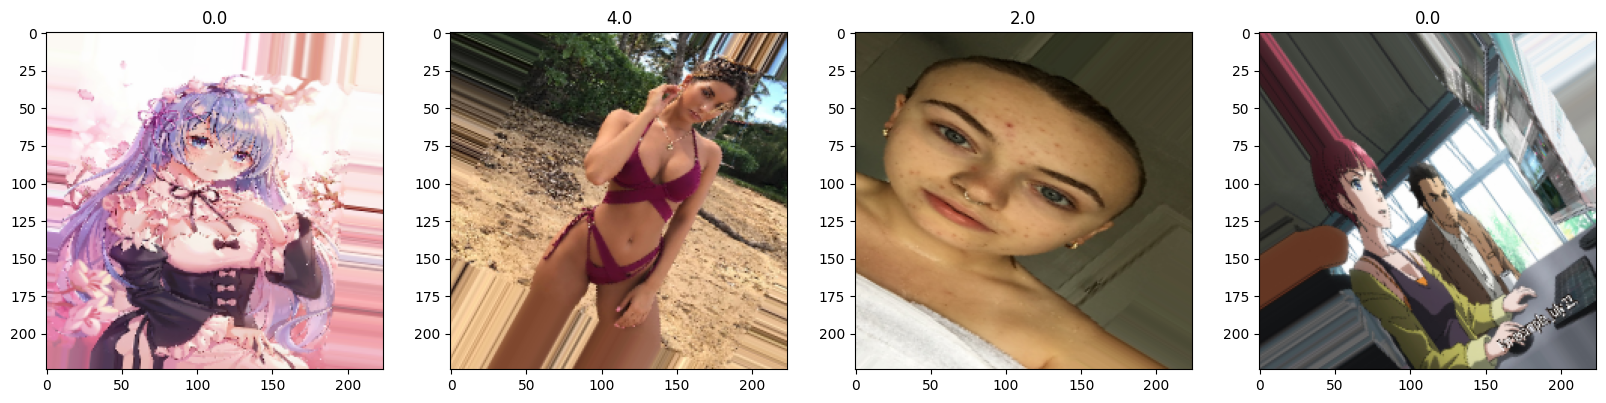

In [95]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [96]:
val_data_iterator = val_set
val_batch = data_iterator.next()
print(val_batch[0].shape[0])
val_batch[0].shape

32


(32, 224, 224, 3)

In [97]:
print(batch[0].max())
print(batch[0].min())

1.0
0.0


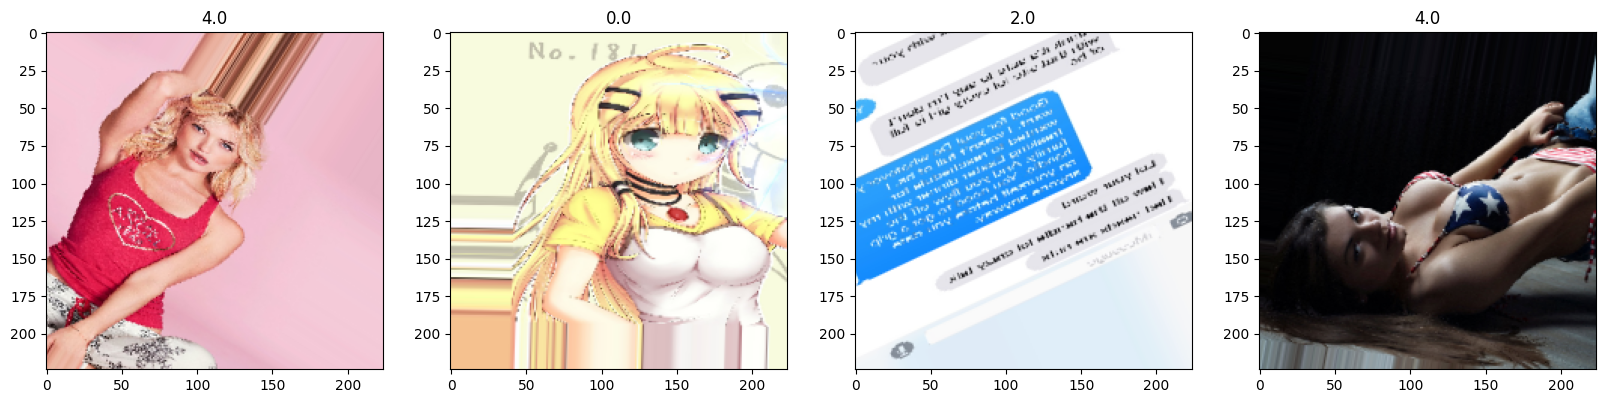

In [98]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(val_batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(val_batch[1][idx])

In [99]:
vgg = VGG16(input_shape=IMAGE_SIZE+[3],weights='imagenet',include_top=False)

In [100]:
for layer in vgg.layers:
    layer.trainable = False

In [101]:
x = Flatten()(vgg.output)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.5)(x)
prediction = Dense(5,activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [102]:
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.metrics import CategoricalAccuracy
adam = optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy',MeanSquaredError(name='val_loss'),CategoricalAccuracy(name='val_accuracy')])

In [103]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint

# checkpoint = ModelCheckpoint(filepath='vgmodel.h5',
#                             verbose=2,
#                             save_best_only=True)

# callbacks = [checkpoint]

log_dir = 'vg_log'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

start = datetime.now()

history = model.fit_generator(train_set,
                              validation_data=val_set,
                              epochs=100,
                              steps_per_epoch=len(train_set)// batch_size,
                              validation_steps=len(val_set)//batch_size,
                              callbacks=[tensorboard_callback],
                             verbose=1)

duration = datetime.now() - start
print("Time taken for training is ",duration)

C:\Users\thala\AppData\Local\Temp\ipykernel_14220\1512723993.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_set,


Epoch 1/100
6/6 [==============================] - 89s 14s/step - loss: 2.9704 - accuracy: 0.2031 - val_loss: 1.6441 - val_accuracy: 0.3125 - val_val_loss: 4.0451 - val_val_accuracy: 0.0625
Epoch 2/100
6/6 [==============================] - 86s 15s/step - loss: 1.8897 - accuracy: 0.3073 - val_loss: 1.8518 - val_accuracy: 0.3125 - val_val_loss: 5.7440 - val_val_accuracy: 0.0938
Epoch 3/100
6/6 [==============================] - 90s 15s/step - loss: 1.6403 - accuracy: 0.4271 - val_loss: 1.1133 - val_accuracy: 0.5312 - val_val_loss: 3.4527 - val_val_accuracy: 0.1562
Epoch 4/100
6/6 [==============================] - 78s 13s/step - loss: 1.3803 - accuracy: 0.4583 - val_loss: 1.6368 - val_accuracy: 0.5000 - val_val_loss: 4.1505 - val_val_accuracy: 0.1250
Epoch 5/100
6/6 [==============================] - 80s 13s/step - loss: 1.4229 - accuracy: 0.4427 - val_loss: 1.2389 - val_accuracy: 0.6250 - val_val_loss: 6.9634 - val_val_accuracy: 0.3750
Epoch 6/100
6/6 [==============================] -

Epoch 44/100
6/6 [==============================] - 75s 13s/step - loss: 0.9244 - accuracy: 0.6354 - val_loss: 0.4165 - val_accuracy: 0.8438 - val_val_loss: 5.5947 - val_val_accuracy: 0.1250
Epoch 45/100
6/6 [==============================] - 75s 13s/step - loss: 0.7771 - accuracy: 0.6823 - val_loss: 1.4548 - val_accuracy: 0.5625 - val_val_loss: 4.4726 - val_val_accuracy: 0.4062
Epoch 46/100
6/6 [==============================] - 80s 13s/step - loss: 0.7810 - accuracy: 0.6979 - val_loss: 0.9438 - val_accuracy: 0.7500 - val_val_loss: 6.0077 - val_val_accuracy: 0.2188
Epoch 47/100
6/6 [==============================] - 78s 13s/step - loss: 0.7939 - accuracy: 0.7240 - val_loss: 0.7148 - val_accuracy: 0.6875 - val_val_loss: 6.0398 - val_val_accuracy: 0.1562
Epoch 48/100
6/6 [==============================] - 78s 13s/step - loss: 0.8733 - accuracy: 0.6771 - val_loss: 1.1079 - val_accuracy: 0.6250 - val_val_loss: 6.0203 - val_val_accuracy: 0.0938
Epoch 49/100
6/6 [===========================

Epoch 87/100
6/6 [==============================] - 77s 13s/step - loss: 0.7673 - accuracy: 0.7031 - val_loss: 0.8848 - val_accuracy: 0.7812 - val_val_loss: 4.6575 - val_val_accuracy: 0.1875
Epoch 88/100
6/6 [==============================] - 77s 13s/step - loss: 0.6816 - accuracy: 0.7604 - val_loss: 0.7899 - val_accuracy: 0.7188 - val_val_loss: 5.9509 - val_val_accuracy: 0.2812
Epoch 89/100
6/6 [==============================] - 77s 13s/step - loss: 0.7829 - accuracy: 0.6979 - val_loss: 0.5273 - val_accuracy: 0.8125 - val_val_loss: 6.4592 - val_val_accuracy: 0.1562
Epoch 90/100
6/6 [==============================] - 78s 13s/step - loss: 0.6714 - accuracy: 0.7552 - val_loss: 0.8570 - val_accuracy: 0.5938 - val_val_loss: 5.1480 - val_val_accuracy: 0.2812
Epoch 91/100
6/6 [==============================] - 78s 13s/step - loss: 0.8849 - accuracy: 0.7031 - val_loss: 0.9743 - val_accuracy: 0.6562 - val_val_loss: 4.0594 - val_val_accuracy: 0.2500
Epoch 92/100
6/6 [===========================

In [29]:
history

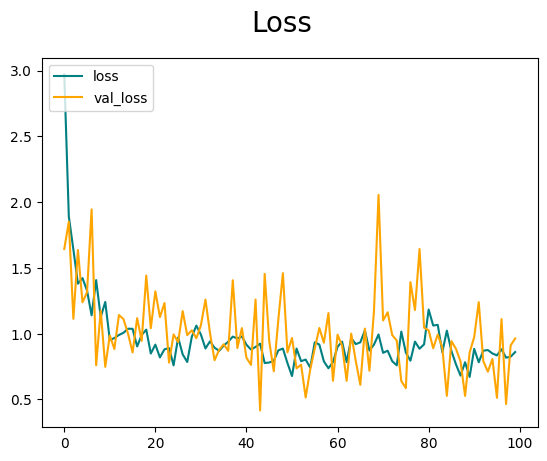

In [104]:
fig = plt.figure()
plt.plot(history.history['loss'],color='teal',label='loss')
plt.plot(history.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

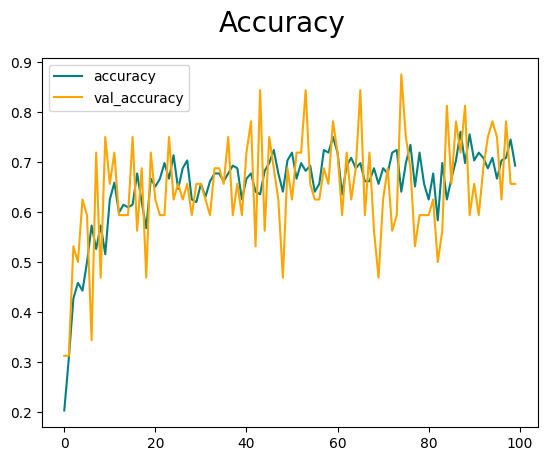

In [105]:
fig = plt.figure()
plt.plot(history.history['accuracy'],color='teal',label='accuracy')
plt.plot(history.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [106]:
model.save('vgg16.h5')